# Chapter 5: 

# Asymmetric Misclassifcation Costs và Tinh Chỉnh Tham Số

Trong chương 3 chúng ta đã khảo sát một số tiêu chí đánh giá chất lượng mô hình phân loại và chúng ta biết rằng với mỗi một tình huống thì lựa chọn một tiêu chí để đánh giá và lựa chọn mô hình phù hợp là quan trọng. Ví dụ với đòi hỏi xây dựng mô hình xác định các giao dịch tài chính gian lận thì Accuracy và thậm chí là cả tiêu chuẩn ROC/AUC là hoàn toàn không phù hợp khi dữ liệu là mất cân bằng. Trong tình huống này chúng ta phải chọn một tiêu chí thích hợp hơn như Recall - tức đo lường khả năng xác định đúng bao nhiêu phần trăm giao dịch là gian lận trong tổng số các cases gian lận thực sự. 


Tương tự là tình huống **bất cân bằng về chi phí khi phân loại sai** (Asymmetric Misclassifcation Costs) - một vấn đề rất phổ biến khi sử dụng các mô hình ML cho bài toán phân loại. Nói cách khác, cái giá phải trả cho việc phân loại sai tạo ra những hậu quả khác nhau nếu chúng ta sử dụng mô hình đó. Hãy lấy một ví dụ, giả sử chúng ta đang sử dụng mô hình X để phân loại một bệnh nhân bị hay không bị nhiễm HIV dựa trên các kết quả xét nghiệm sinh hóa của họ. Rõ ràng việc phân loại sai "một bệnh nhân thực sự bị HIV thành không nhiễm HIV" sẽ gây hậu quả lớn hơn nhiều khi phân loại sai "một bệnh nhân không nhiễm HIV thành bị nhiễm HIV". 

Tương tự như vậy, với một tổ chức tài chính như ngân hàng thương mại thì hậu quả của việc phân loại sai "khách hàng thực sự tốt được phân loại thành xấu" sẽ chỉ là việc mất đi cơ hội kiếm được phần trăm lãi ứng với khoản vay được đề nghị của khách hàng đó nhưng nếu phân loại sai "khách hàng là xấu nhưng được phân loại thành tốt" thì ngân hàng gần như mất trắng khoản tiền đã cho vay. 

Những phân tích trên, trong bối cảnh bài toán phân loại và xếp hạng tín dụng dẫn đến hệ quả là: 

- Hệ quả 1: Mô hình X có Accuracy (hoặc là AUC/ROC) cao hơn mô hình Y có thể lại là mô hình gây ra lỗ nhiều hơn cho ngân hàng. 
- Do tồn tại hệ quả 1 nên dẫn đến hệ quả 2 như sau: tiêu chí để so sánh, đánh giá và lựa chọn mô hình phân loại cần căn cứ vào tác động kinh tế (tức lãi - lỗ bao nhiêu) của việc sử dụng mô hình chứ không phải là các tiêu chí như ROC/AUC, Accuracy hay Recall. 

Trong chương 2 chúng ta đã biết cách thức tinh chỉnh tham số tối ưu cho các mô hình ML dựa trên một tiêu chí nào đó. Tiêu chí đó thường là ROC/AUC cho bài toán phân loại nhị phân (tức biến Y chỉ có hai nhãn - hai giá trị). Tiêu chí đó cũng có thể là Recall (hoặc rất nhiều tiêu chí khác chúng ta có thể chọn trong menu sẵn có của thư viện Scikit Learn). Tuy nhiên việc tinh chỉnh tham số, so sánh và lựa chọn mô hình căn cứ vào tiêu chuẩn lợi nhuận thì lại không được giải quyết. 

Chương này hướng dẫn thực hành nhă đưa ra kết quả thực nghiệm để trả lời các câu hỏi sau: 

- Với các tiêu chí tinh chỉnh mô hình khác nhau thì tác động sẽ như thế nào đến lợi nhuận? 
- Do có sự đánh đổi giữa các tiêu chí khi ngưỡng được lựa chọn cho phân loại thay đổi thì lợi nhuận thay đổi ra sao? 

Việc làm rõ các câu hỏi trên sẽ là căn cứ để chúng ta xây dựng và lựa chọn một mô hình tốt nhất để thỏa mãn đòi hỏi của hầu hết các tổ chức vì lợi nhuận: lợi nhuận cao nhất có thể. Với **các tổ chức kinh doanh vì lợi nhuận thì tiêu chuẩn đầu tiên mà chúng quan tâm là lợi nhuận (Profit) chứ không phải các tiêu chí ưa thích của những người làm mô hình nói chung và người làm thống kê nói riêng là Accuracy, Recall hay ROC/AUC**. 

Về Asymmetric Misclassifcation Costs bạn đọc có thể cần tham khảo kĩ hơn ở trang 133 cuốn [Data Mining for Business Analytics: Concepts, Techniques, and Applications in R](https://www.dataminingbook.com/book/r-edition). Để minh họa chúng ta trở lại với bộ số liệu *UniversalBank.csv* được sử dụng nhiều lần trong textbook này:  

In [1]:
# Đọc dữ liệu: 
import pandas as pd
df_bank = pd.read_csv("C:/Users/Zbook/Desktop/DataMining/dmba/UniversalBank.csv")

#============================
#   Chuẩn bị dữ liệu 
#============================

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["ZIP Code", "ID"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["Personal Loan"]
X = my_df_binary.drop("Personal Loan", 1)

# Phân chia dữ liệu theo tỉ lệ 60 - 40: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, 
                                                    random_state = 29, stratify = Y)

Thiết lập lưới tinh chỉnh tham số cho mô hình Random Forest (RF) như đã biết ở [chương 2](https://github.com/ChiDungNguyen/Chapter-2-Tinh_Chinh_Tham_So/blob/master/Chapter2_Turning_parameters(UniversalBank.csv).ipynb): 

In [2]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"max_depth": [2, 3, None],
              "n_estimators": [500, 700, 1000],
              "max_features": [3, 5, 10],
              "min_samples_split": [3, 5, 10],
              "min_samples_leaf": [3, 5, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Viết hàm tinh chỉnh tham số tối ưu cho RF theo tiêu chí được lựa chọn theo Random Search: 

In [3]:
# Hàm tinh chỉnh và huấn luyện RF theo một tiêu chí được chọn trước: 

from sklearn.model_selection import RandomizedSearchCV

def turning_RF(metric_selected):
    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=29),
                                   param_distributions=param_grid,
                                   cv=5,              
                                   n_iter=48,         
                                   scoring=metric_selected,
                                   n_jobs=-1,           
                                   random_state=29)

    rf_random.fit(X_train, y_train)
    return(rf_random) 

Thực hiện huấn luyện và tinh chỉnh các mô hình RF theo các tiêu chí là Accuracy, Recall và ROC/AUC đồng thời tính toán thời gian thực hiện: 

In [4]:
# Thực hiện tinh chỉnh RF theo các tiêu chí Accurracy, Recall và ROC/AUC và tính thời gian huấn luyện: 
import time
start_time=time.time()

rf_acc = turning_RF(metric_selected="accuracy")
rf_rec = turning_RF(metric_selected="recall")
rf_roc = turning_RF(metric_selected="roc_auc")

training_time = time.time() - start_time
print("Thời gian tinh chỉnh:", training_time)

Thời gian tinh chỉnh: 506.4117588996887


Kết quả là mất 231 giây để tinh chỉnh. Cấu hình máy tính khác nhau thì con số này sẽ khác và với cùng một máy tính thì con số này cũng khác. Dưới đây là kết quả cho thấy các tham số tốt nhất tương ứng với tiêu chí tinh chỉnh được chọn: 

In [5]:
# Giá trị tốt nhất của tham số tương ứng với một tiêu chí được chọn: 
print("Tham số tốt nhất với tiêu chí Accuracy:", rf_acc.best_params_)
print("Tham số tốt nhất với tiêu chí Recall:", rf_rec.best_params_)
print("Tham số tốt nhất với tiêu chí AUC/ROC:", rf_roc.best_params_)

Tham số tốt nhất với tiêu chí Accuracy: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Tham số tốt nhất với tiêu chí Recall: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Tham số tốt nhất với tiêu chí AUC/ROC: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


Với các tiêu chuẩn được chọn để tinh chỉnh tham số khác nhau thì những giá trị tối ưu của tham số cũng khác như có thể thấy ở kết quả trên. Chúng ta sử dụng các mô hình RF với các tham số tối ưu tương ứng để thực hiện dự báo cho sự kiện "khách hàng đi vay là xấu" như sau: 

In [6]:
# Các mô hình RF tối ưu tương ứng với tiêu chí tinh chỉnh được chọn: 
best_rf_acc = rf_acc.best_estimator_
best_rf_rec = rf_rec.best_estimator_
best_rf_roc = rf_roc.best_estimator_

In [7]:
# Sử dụng các mô hình RF thực hiện dự báo nhãn 0 - 1 cho các cases:  
pred_acc = best_rf_acc.predict(X_test)
pred_rec = best_rf_rec.predict(X_test)
pred_roc = best_rf_roc.predict(X_test)

Chú ý rằng các nhãn 0 (tương ứng với khách hàng tốt) và 1 (tương ứng với khách hàng xấu) ở được dự báo dựa trên ước lượng về xác suất phá sản PD (Probability of Default) với ngưỡng (cutoff) mặc định là 0.5. Chúng ta thực hiện dự báo PD như sau: 

In [18]:
# PD thu được từ RF tinh chỉnh theo các tiêu chí khác nhau: 
pred_prob_rec = best_rf_rec.predict_proba(X_test)
pred_prob_acc = best_rf_acc.predict_proba(X_test)
pred_prob_roc = best_rf_roc.predict_proba(X_test)

# 5.1 Biến đổi của Profit theo ngưỡng Cutoff được lựa chọn

Một khách hàng sẽ được phân loại là tốt hay xấu phụ thuộc vào hai yếu tố: (1) xác suất PD dự báo từ mô hình, và (2) ngưỡng cutoff được lựa chọn để phân loại khách hàng dựa trên PD thu được từ mô hình. Vấn đề này đã được giải thích trong chương 2. 

Giả sử rằng: (1) nếu được đồng ý cho vay bởi ngân hàng thì mỗi một khách hàng sẽ được giải ngân một khoản vay đúng bằng thu nhập của họ (thực tế các ngân hàng Việt Nam khi cấp tín dụng tiêu dùng, nếu khách hàng thỏa mãn thì họ sẽ được cấp một khoản vay thường là từ 1 đến 10 lần thu nhập sau thuế của họ tùy theo nhóm khách hàng), và (2) một khách hàng là xấu nhưng RF phân loại nhầm thành tốt thì ngân hàng sẽ mất trắng khoản vay. Dưới đây chúng ta viết hàm tình lãi thu về của ngân hàng với các giả định trên khi lãi suất là 10%:  

In [9]:
# Viết hàm tình lợi nhuận: 
import numpy as np

def profit_by_cutoff(cutoff, pred_prob):
    
    # Phân loại 0 hay là 1 dựa trên PD và cutoff được chọn: 
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int) 
    # Các cases là 0 được phân loại đúng thành 0: 
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    # Các cases là 1 nhưng bị phân loại nhầm thành 0: 
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    # Tính Profit: 
    profit = np.sum(0.10*gg["Income"]) - np.sum(bg["Income"])
    return(profit)

Với lãi suất là 10% chẳng hạn thì lãi thu về của ngân hàng tương ứng với các mô hình RF lần lượt là: 

In [10]:
# Lợi nhuận nếu RF được tinh chỉnh theo tiêu chí Accuracy: 
profit_by_cutoff(cutoff=0.5, pred_prob=pred_prob_acc)

10196.6

In [11]:
# Lợi nhuận nếu RF được tinh chỉnh theo tiêu chí Recall: 
profit_by_cutoff(cutoff=0.5, pred_prob=pred_prob_rec)

10419.7

In [12]:
# Lợi nhuận nếu RF được tinh chỉnh theo tiêu chí ROC/AUC" 
profit_by_cutoff(cutoff=0.5, pred_prob=pred_prob_roc)

9933.0

Như vậy RF được tinh chỉnh theo tiêu chí Recall sẽ tạo ra nhiều lợi nhuận nhất cho ngân hàng. Tuy nhiên cần lưu ý là các kết quả này sử dụng ngưỡng mặc định 0.5 để phân loại khách hàng. Python codes dưới đây được sử dụng để khảo sát lợi nhuận biến đổi ra sao khi ngưỡng này thay đổi: 

In [14]:
# Viết hàm tính toán Profit theo ngưỡng cutoff: 
def profit_ByCutoffRange(prob, cutoff_range):
    profit = []
    for i in cutoff_range:
        profit_i = profit_by_cutoff(cutoff=i, pred_prob=prob)
        profit.append(profit_i)
        
    df_results = pd.DataFrame({"Cutoff": np.round(cutoff_range, 4), "Profit": profit})
    return(df_results)                      

In [19]:
# Các ngưỡng khác nhau của cutoff: 
cutoff_range_profit = np.arange(0.025, 0.6, 0.025) 

# Tính toán Profit tương ứng với các kịch bản khác nhau của cutoff: 
df_profit_roc = profit_ByCutoffRange(prob=pred_prob_roc, cutoff_range=cutoff_range_profit)
df_profit_rec = profit_ByCutoffRange(prob=pred_prob_rec, cutoff_range=cutoff_range_profit)
df_profit_acc = profit_ByCutoffRange(prob=pred_prob_acc, cutoff_range=cutoff_range_profit)

Profit dưới các kịch bản khách nhau của cutoff và tiêu chí được lựa chọn cho tinh chỉnh RF (Figure 1): 

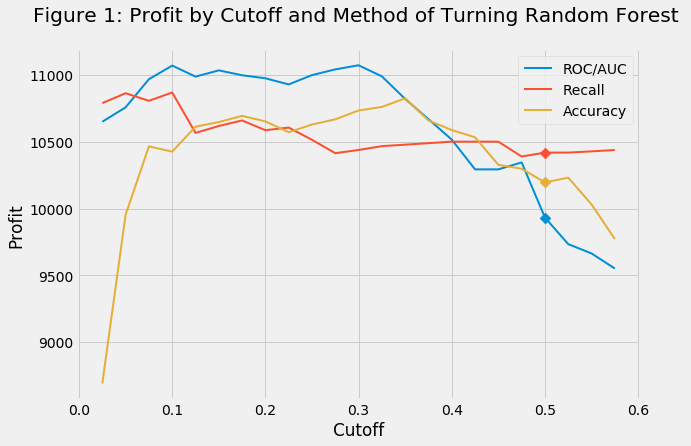

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

plt.figure(figsize = (9, 6))
# Plot lines: 
plt.plot("Cutoff", "Profit", data = df_profit_roc, label = "ROC/AUC", lw = 2)
plt.plot("Cutoff", "Profit", data = df_profit_rec, label = "Recall", lw = 2)
plt.plot("Cutoff", "Profit", data = df_profit_acc, label = "Accuracy", lw = 2)
# Plot points with highest profits: 
plt.scatter("Cutoff", "Profit", data = df_profit_roc[df_profit_roc["Cutoff"] == 0.5], marker = "D", s = 60, label = None)
plt.scatter("Cutoff", "Profit", data = df_profit_rec[df_profit_rec["Cutoff"] == 0.5], marker = "D", s = 60, label = None)
plt.scatter("Cutoff", "Profit", data = df_profit_acc[df_profit_acc["Cutoff"] == 0.5], marker = "D", s = 60, label = None)
# Add axis labels + tittle: 
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 1: Profit by Cutoff and Method of Turning Random Forest \n")
plt.legend()
plt.show()

Chúng ta có thể minh họa lợi nhuận tương ứng với kịch bản tốt nhất của cutoff cho các mô hình RF được tinh chỉnh theo các tiêu chí khác nhau như sau: 

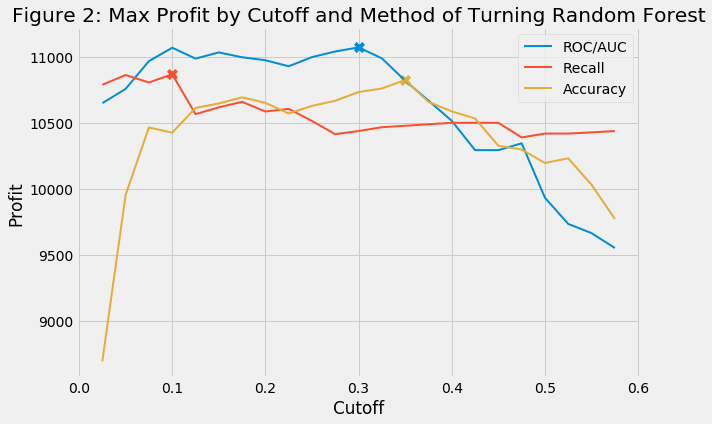

In [21]:
# Lấy ra data frame về lợi nhuận cao nhất: 
max_pro_roc = df_profit_roc[df_profit_roc["Profit"] == df_profit_roc["Profit"].max()]
max_pro_rec = df_profit_rec[df_profit_rec["Profit"] == df_profit_rec["Profit"].max()]
max_pro_acc = df_profit_acc[df_profit_acc["Profit"] == df_profit_acc["Profit"].max()]

plt.figure(figsize = (9, 6))
# Plot line: 
plt.plot("Cutoff", "Profit", data = df_profit_roc, label = "ROC/AUC", lw = 2)
plt.plot("Cutoff", "Profit", data = df_profit_rec, label = "Recall", lw = 2)
plt.plot("Cutoff", "Profit", data = df_profit_acc, label = "Accuracy", lw = 2)
# Plot point: 
plt.scatter("Cutoff", "Profit", data = max_pro_roc, marker = "x", s = 70, label = None)
plt.scatter("Cutoff", "Profit", data = max_pro_rec, marker = "x", s = 70, label = None)
plt.scatter("Cutoff", "Profit", data = max_pro_acc, marker = "x", s = 70, label = None)
# Add axis labels + title: 
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 2: Max Profit by Cutoff and Method of Turning Random Forest")
plt.legend()
plt.show()

Các kịch bản của cutoff tạo ra lợi nhuận tốt nhất cho ngân hàng tương ứng với các tiêu chí được chọn cho tinh chỉnh RF là: 

In [22]:
max_pro_roc # RF tinh chỉnh theo ROC/AUC. 

,Cutoff,Profit
11,0.3,11073.7


In [23]:
max_pro_rec # RF tinh chỉnh theo Recall. 

,Cutoff,Profit
3,0.1,10869.8


In [24]:
max_pro_acc # RF tinh chỉnh theo Accuracy. 

,Cutoff,Profit
13,0.35,10826.4


Logistic Classifier là một cách tiếp cận của thống kê truyền thống và performance của nó sẽ được coi như là *chuẩn đánh giá* (hay Base Line) để đánh giá các cách tiếp cận khác nhau của Machine Learning. Dưới đây chúng ta khảo sát lợi nhuận nếu ngân hàng sử dụng Logistic Regression cho phân loại: 

In [25]:
# Huấn luyện Logistic: 
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

# Sử dụng mô hình Logistic thực hiện dự báo PD: 
pred_prob_logit = logmodel.predict_proba(X_test)

# Các kịch bản khác lợi nhuận của Logistic: 
df_profit_logit = profit_ByCutoffRange(prob=pred_prob_logit, cutoff_range=cutoff_range_profit)

# Kịch bản có lợi nhuận tốt nhất: 
max_pro_logit = df_profit_logit[df_profit_logit['Profit'] == df_profit_logit['Profit'].max()]
max_pro_logit

C:\Users\Zbook\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Cutoff,Profit
4,0.125,7626.8


Có thể thấy rằng lợi nhuận từ kịch bản tốt nhất nếu sử dụng Logistic sẽ kém xa so với sử dụng RF bất kể RF được tinh chỉnh theo tiêu chí nào. So với phương án RF tinh chỉnh theo Accuracy tạo ra Profit thấp nhất thì cũng chênh lệch nhau 42%: 

In [34]:
np.array(max_pro_acc["Profit"]) / np.array(max_pro_logit["Profit"]) - 1

array([0.41952064])

Chúng ta có thể minh họa các kịch bản của lợi nhuận cho Logistic với điểm màu đỏ ứng với kịch bản tốt nhất còn điểm màu tím ứng với ngưỡng mặc định 0.5 của cutoff: 

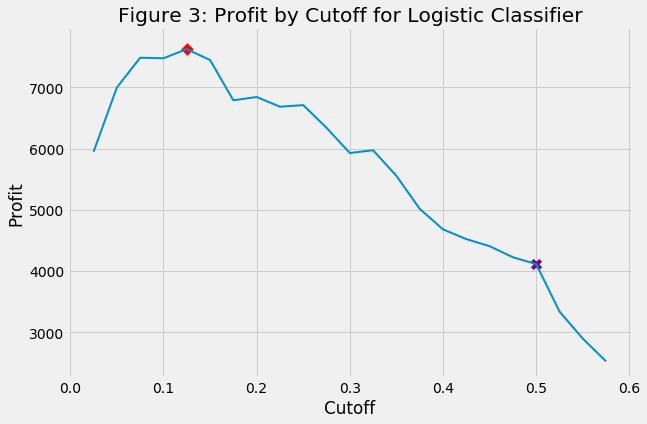

In [37]:
plt.figure(figsize = (9, 6))
plt.plot("Cutoff", "Profit", data = df_profit_logit, lw = 2)
plt.scatter("Cutoff", "Profit", data = max_pro_logit, marker = "D", color = "red", s = 70)
plt.scatter("Cutoff", "Profit", 
            data = df_profit_logit[df_profit_logit["Cutoff"] == 0.5], 
            marker = "x", s = 70, color = "purple", label = None)
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 3: Profit by Cutoff for Logistic Classifier")
plt.show()

Các kết quả thực nghiệm ở trên chỉ ra rằng:

- **Ở ngưỡng mặc định 0.5 thì Profit cao nhất thuộc về RF tinh chỉnh theo Recall và thấp nhất là tinh chỉnh theo Accuracy**. Kết quả này chúng ta đã biết trước. 
- **Lợi nhuận sẽ cao nhất nếu: (1) RF được tinh chỉnh theo tiêu chí ROC/AUC, và (2) tại ngưỡng cutoff = 0.3**. 
- **Cách tiếp cận của thống kê truyền thống là Logistic tạo ra lợi nhuận tệ nhất cho ngân hàng**. 

Như vậy với mục tiêu *lợi nhuận trên hết* thì RF được tinh chỉnh theo ROC/AUC với cutoff = 0.3 sẽ thỏa mãn mục tiêu này.  

# 5.2 Biến đổi của Accuracy theo ngưỡng Cutoff được lựa chọn

Những kết quả ở trên dẫn đến một kết luận rằng: 

- Một mô hình có Accuracy cao có thể lại là mô hình mang lại lợi nhuận không tốt cho ngân hàng. 
- Kịch bản tốt nhất cho Accuracy không phải là kịch bản tốt nhất cho lợi nhuận. 

Chúng ta có thể khảo sát biến đổi của Accuracy theo cutoff để đưa ra bằng chứng thực nghiệm cho hai kết luận ở trên như sau: 

In [38]:
# Viết hàm tính Accuracy theo cutoff: 

def accuracy_ByCutoffRange(prob_pred, cutoff_range): 
    
    accuracy = []
    
    for j in cutoff_range:
        pred_bg = (prob_pred[:, 1] >= j).astype(int)
        acc_i = np.mean(pred_bg == y_test)
        accuracy.append(acc_i)
    df_accuracy = pd.DataFrame({"Cutoff": np.round(cutoff_range, 4), "Accuracy": accuracy})    
    return(df_accuracy)

In [39]:
# Các giá trị của cutoff được khảo sát: 
cutoff_range_acc = np.arange(0.025, 1, 0.025)

# Accuracy tương ứng: 
accuracy_RF_acc = accuracy_ByCutoffRange(prob_pred=pred_prob_acc, cutoff_range=cutoff_range_acc)
accuracy_RF_rec = accuracy_ByCutoffRange(prob_pred=pred_prob_rec, cutoff_range=cutoff_range_acc)
accuracy_RF_roc = accuracy_ByCutoffRange(prob_pred=pred_prob_roc, cutoff_range=cutoff_range_acc)
accuracy_logit = accuracy_ByCutoffRange(prob_pred=pred_prob_logit, cutoff_range=cutoff_range_acc)

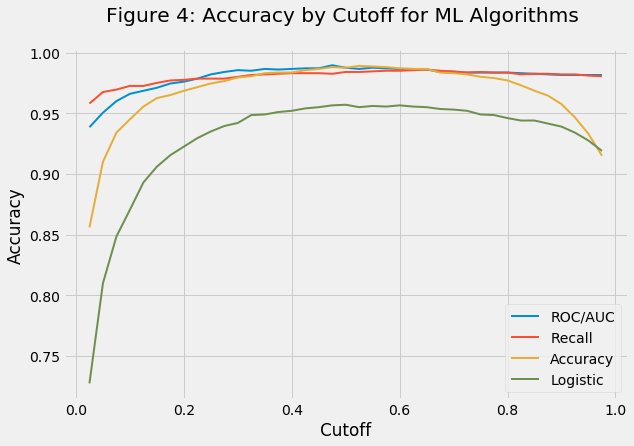

In [43]:
# Biến đổi của Accuracy theo cutoff: 
plt.figure(figsize = (9, 6))
plt.plot("Cutoff", "Accuracy", data = accuracy_RF_roc, label = "ROC/AUC", lw = 2)
plt.plot("Cutoff", "Accuracy", data = accuracy_RF_rec, label = "Recall", lw = 2)
plt.plot("Cutoff", "Accuracy", data = accuracy_RF_acc, label = "Accuracy", lw = 2)
plt.plot("Cutoff", "Accuracy", data = accuracy_logit, label = "Logistic", lw = 2)
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")
plt.title("Figure 4: Accuracy by Cutoff for ML Algorithms \n")
plt.legend()
plt.show()

Từ figure 4 có thể thấy Logistic vẫn là mô hình kém nhất ngay cả trong tình huống ngân hàng không chọn Profit mà là Accuracy để đánh giá và lựa chọn mô hình sử dụng. Mặt khác cũng ta cũng có thể thấy rằng ngưỡng đạt Accuracy tốt nhất không phải là ngưỡng để đạt được Profit tốt nhất cho ngân hàng. Điều này một lần nữa khẳng định rằng việc đưa ra các giải pháp phù hợp với cái gọi là **Business Sense** sẽ có thể khác với cách nhìn và giải quyết vấn đề nếu chỉ thuần túy là **Data Science**. 

Không phải AUC/ROC, Accuracy, Recall hay bất cứ tiêu chí nào khác của khoa học dữ liệu được chọn để tinh chỉnh cũng như so sánh - lựa chọn mô hình cho mục đích sử dụng. Với các tổ chức kinh doanh thì tiêu chuẩn vàng (và luôn là như thế) sẽ là **lợi nhuận**. 

# 5.3 Kết luận

Dựa trên các kết quả thực nghiệm thu được với bộ số liệu UniversalBank.csv chúng ta thấy rằng với bài toán phân loại và xếp hạng hồ sơ xin vay thì tiêu chí phù hợp để tinh chỉnh và lựa chọn mô hình trước hết phải căn cứ vào mục tiêu kinh doanh của tổ chức mà trước hết là lợi nhuận. Điều này hàm ý rằng không phải AUC/ROC, Accuracy, Recall hay bất cứ tiêu chí nào khác của khoa học dữ liệu được chọn để tinh chỉnh cũng như so sánh - lựa chọn mô hình cho mục đích sử dụng mà là lợi nhuận. 


# Tài liệu tham khảo

1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.

2. Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. New York: Springer.

3. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. O'Reilly Media, Inc.

4. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.

5. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons.